In [2]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# CHAPTER 5. 서포트 벡터 머신

- **서포트 벡터 머신**<sup>Support Vector Machine</sup>(SVM) : 매우 강력하고 선형이나 비선형 분류, 회귀, 이상치 탐색에도 사용할 수 있는 다목적 머신러닝 모델<br>
- 특히 복잡한 분류 문제에 잘 들어맞으며 작거나 중간 크기의 데이터셋에 적합

---
## 5.1 선형 SVM 분류

<img src="./images/figure5-1.png" width="100%">
<center>**그림 5-1 라지 마진 분류**</center>

- SVM의 기본 아이디어 ([그림 5-1]은 붓꽃 데이터셋의 일부)<br>
  - 왼쪽 그래프에 세 개의 선형 분류기에서 만들어진 결정 경계가 보임
   - 점선 모델은 클래스를 적절하게 분류하지 못하고 있고, 다른 두 모델은 결정 경계가 샘플에 너무 가까워 새로운 샘플에 대해서는 잘 작동하지 못할 것
  - 오른쪽 그래프에 있는 실선은 SVM 분류기의 결정 경계
   - 이 직선은 두 개의 클래스를 나누고 있고 제일 가까운 훈련 샘플로부터 가능한 한 멀리 떨어져 있음
   - SVM 분류기를 클래스 사이에 가장 폭이 넓은 도로를 찾는 것으로 생각할 수 있음. 그래서 **라지 마진 분류**<sup>large margin classification</sup>라고 함
   - 도로 바깥쪽에 훈련 샘플을 추가해도 결정 경계에는 영향을 미치지 않음
   - 도로 경계에 위치한 샘플에 의해 전적으로 결정됨. 이런 샘플을 **서포트 벡터**<sup>support vector</sup>라고 함([그림 5-1]에 동그라미 표시)

- SVM은 특성의 스케일에 민감
- 특성의 스케일을 조정하면 결정 경계가 훨씬 좋아짐([그림 5-2]의 오른쪽 그래프)

<img src="./images/figure5-2.png" width="100%">
<center>**그림 5-2 특성 스케일에 따른 민감성**</center>

### 5.1.1 소프트 마진 분류

- **하드 마진 분류**<sup>hard margin classification</sup> : 모든 샘플이 도로 바깥쪽에 올바르게 분류됨
- 하드 마진 분류의 두 가지 문제점
 - 데이터가 선형적으로 구분될 수 있어야 제대로 작동
 - 이상치에 민감
 - [그림 5-3]의 왼쪽 그래프에서는 이상치가 하나 있어 하드 마진을 찾을 수 없고, 오른쪽 그래프의 결정 경계는 [그림 5-1]과 매우 다르고 일반화가 잘될 것 같지 않음

<img src="./images/figure5-3.png" width="100%">
<center>**그림 5-3 이상치에 민감한 하드 마진**</center>

- 이런 문제를 피하려면 좀 더 유연한 모델이 필요함
- 도로의 폭을 가능한 한 넓게 유지, **마진 오류**<sup>margin violation</sup>(즉, 샘플이 도로 중간이나 심지어 반대쪽에 있는 경우) 사이에 적절한 균형을 잡아야 함
- 이를 **소프트 마진 분류**<sup>soft margin classification</sup>라고 함

- 사이킷런의 SVM 모델에서는 C 하이퍼파라미터를 사용해 이 균형을 조절할 수 있음
- C 값을 줄이면 도로의 폭이 넓어지지만 마진 오류도 커짐
- [그림 5-4]의 왼쪽을 보면 큰 C 값을 사용해 분류기가 마진 오류를 적게 냈지만 마진이 좁아졌음
- 오른쪽에서는 작은 C 값을 사용해 마진이 넓어졌지만 많은 샘플이 도로 안에 포함되었음. 그러나 더 잘 일반화될 것 같아 보임
- 대부분의 마진 오류는 결정 경계를 기준으로 올바른 클래스로 분류되기 때문에 이 훈련 세트에서 예측 에러는 마진 오류보다 작음

<img src="./images/figure5-4.png" width="100%">
<center>**그림 5-4 좁은 마진과 넓은 마진**</center>

다음 코드는 붓꽃 데이터셋을 적재하고, 특성 스케일을 변경하고, Iris-Virginia 품종을 감지하기 위해 선형 SVM 모델을 훈련시킴<br>
(C=1, **힌지 손실**<sup>hinge loss</sup>함수를 적용한 LinearSVC 클래스를 사용)

In [3]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64)  # Iris-Virginica

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ])

svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

In [4]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

- LinearSVC는 규제에 편향을 포함. 그래서 훈련 세트에서 평균을 빼서 중앙에 맞춰야 함
- StandardScaler를 사용하여 데이터 스케일을 맞추면 자동으로 됨
- loss 매개변수를 "hinge"로 지정해야 함(기본값은 "squared_hinge")
- 훈련 샘플보다 특성이 많지 않다면 성능을 높이기 위해 dual 매개변수를 False로 지정

---
## 5.2 비선형 SVM 분류

- 비선형 데이터셋을 다루는 한 가지 방법은 다항 특성과 같은 특성을 더 추가하는 것
- [그림 5-5]의 왼쪽 그래프는 하나의 특성 x<sub>1</sub>만을 가짐. 이 데이터셋은 선형적으로 구분이 안 됨
- 하지만 두 번째 특성 x<sub>2</sub> = (x<sub>1</sub>)<sup>2</sup>을 추가하여 만들어진 2차원 데이터셋은 선형적으로 구분할 수 있음

<img src="./images/figure5-5.png" width="80%">
<center>**그림 5-5 특성을 추가하여 선형적으로 구분되는 데이터셋 만들기**</center>

- 사이킷런의 PolynomialFeatures를 사용해 특성을 추가
- 이를 moons 데이터셋에 적용(사이킷런의 make_moons 함수를 사용해서 만든 두 개의 반달 모양 데이터셋)

사이킷런 0.20 버전부터는 LinearSVC가 max_iter 반복 안에 수렴하지 않을 경우 반복 횟수 증가 경고가 나옵니다. 경고 메세지를 피하기 위해 max_iter 매개변수의 기본값을 1,000에서 2,000으로 증가시킵니다.

In [5]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", max_iter=2000, random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('poly_features', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=2000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

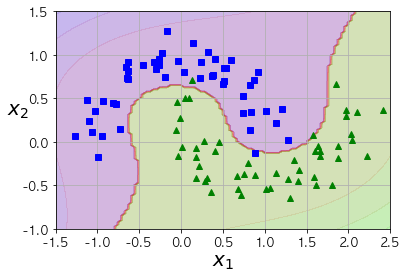

In [6]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
    
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

### 5.2.1 다항식 커널

- 낮은 차수의 다항식은 매우 복잡한 데이터셋을 잘 표현하지 못함
- 높은 차수의 다항식은 굉장히 많은 특성을 추가하므로 모델을 느리게 만듦
- SVM을 사용할 땐 **커널 트릭**<sup>kernel trick</sup>이라는 수학적 기교를 적용하여 특성을 추가하지 않으면서 다항식 특성을 많이 추가한 것과 같은 결과를 얻을 수 있음

In [7]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=5, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

- 매개변수 coef0는 모델이 높은 차수와 낮은 차수에 얼마나 영향을 받을지 조절
- coef0 매개변수는 [식 5-10]의 다항식 커널에 있는 상수항 r
- 다항식 커널은 차수가 높아질수록 1보다 작은 값과 1보다 큰 값의 차이가 크게 벌어지므로 coef0을 적절한 값으로 지정하면 고차항의 영향을 줄일 수 있음

In [8]:
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=5, cache_size=200, class_weight=None, coef0=100,
  decision_function_shape='ovr', degree=10, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

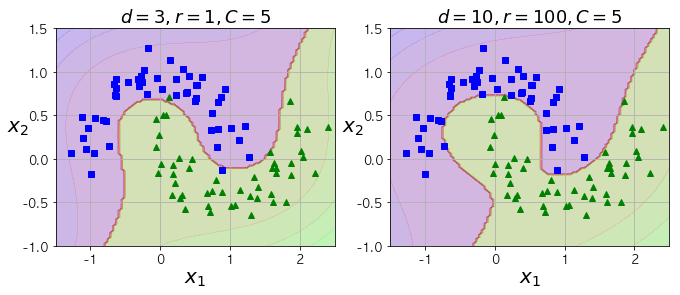

In [9]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.subplot(122)
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)

plt.show()

- 왼쪽 그래프는 3차 다항식 커널을 사용한 SVM 분류기, 오른쪽은 10차 다항식 커널을 사용한 SVM 분류기
- 모델이 과대적합이라면 다항식의 차수를 줄이고 과소적합이라면 차수를 늘려야 함

### 5.2.2 유사도 특성 추가

- 비선형 특성을 다루는 또 다른 기법은 각 샘플이 특정 **랜드마크**<sup>landmark</sup>와 얼마나 닮았는지 측정하는 **유사도 함수**<sup>similarity function</sup>로 계산한 특성을 추가하는 것
- [그림 5-8]의 왼쪽 그래프는 두 개의 랜드마크 x<sub>1</sub> = -2와 x<sub>2</sub> = 1을 추가

<img src="./images/figure5-8.png" width="80%">
<center>**그림 5-8 가우시안 RBF를 사용한 유사도 특성**</center>

<img src="./images/equation5-1.png" width="60%">
<center>**식 5-1 가우시안 RBF**</center>

- $\gamma$ = 0.3인 가우시안 **방사 기저 함수**<sup>Radial Basis Function</sup>(RBF)를 유사도 함수로 정의
- 이 함수의 값은 0부터 1까지 변화하며 종 모양으로 나타남
- [식 5-1]의 $\ell$이 랜드마크 지점. $\gamma$는 0보다 커야 하며 값이 작을수록 폭이 넓은 종 모양
- [그림 5-8]의 x<sub>1</sub> = -1 샘플을 살펴보면,
 - 첫 번째 랜드마크에서 1만큼 떨어져 있고 두 번째 랜드마크에서 2만큼 떨어져 있음
 - 그러므로 새로 만든 특성은 x<sub>2</sub> = exp(-0.3 &times; 1<sup>2</sup>) &asymp; 0.74와 x<sub>3</sub> = exp(-0.3 &times; 2<sup>2</sup>) &asymp; 0.30

- 랜드마크를 선택하는 간단한 방법은 데이터셋에 있는 모든 샘플 위치에 랜드마크를 설정하는 것
- 이렇게 하면 차원이 매우 커져 변환된 훈련 세트가 선형적으로 구분될 가능성이 높음
- 단점은 훈련 세트에 있는 n개의 특성을 가진 m개의 샘플이 m개의 특성을 가진 m개의 샘플로 변환됨(원본 특성은 제외한다고 가정)
- 훈련 세트가 매우 클 경우 동일한 크기의 아주 많은 특성이 만들어짐

### 5.2.3 가우시안 RBF 커널

- 유사도 특성 방식에서 추가 특성을 모두 계산하려면 연산 비용이 많이 듦
- 하지만 커널 트릭을 적용하면 유사도 특성을 많이 추가하는 것과 같은 비슷한 결과를 실제로 특성을 추가하지 않고 얻을 수 있음

SVC 모델에 가우시안 RBF 커널을 적용

In [10]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

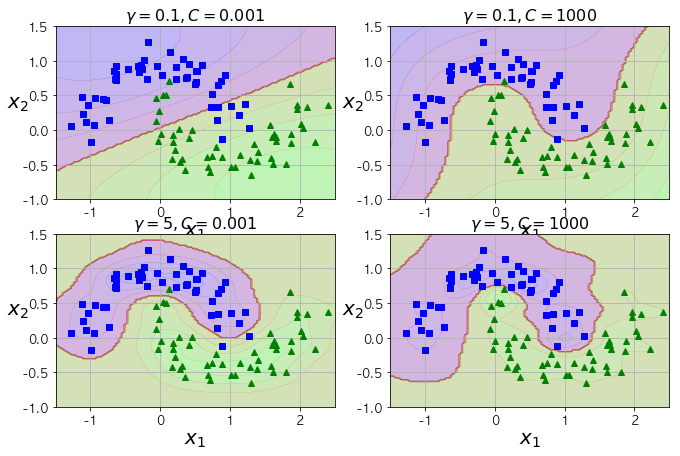

In [11]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

plt.figure(figsize=(11, 7))

for i, svm_clf in enumerate(svm_clfs):
    plt.subplot(221 + i)
    plot_predictions(svm_clf, [-1.5, 2.5, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    
plt.show()

- gamma 증가
 - 종 모양 그래프가 좁아져서([그림 5-8] 참고) 각 샘플의 영향 범위가 작아짐
 - 결정 경계가 조금 더 불규칙해지고 각 샘플을 따라 구불구불하게 휘어짐
- gamma 감소
 - 넒은 종 모양 그래프를 만들며 샘플이 넓은 범위에 걸쳐 영향을 주므로 결정 경계가 더 부드러워짐
- 결국 하이퍼파라미터 $\gamma$가 규제의 역할
- 모델이 과대적합일 경우엔 감소, 과소적합일 경우엔 증가(하이퍼파라미터 C와 비슷)

- 다른 커널은 거의 사용되지 않고 어떤 커널은 특정 데이터 구조에 특화되어 있음
- **문자열 커널**<string kernel</sup>이 가끔 텍스트 문서나 DNA 서열을 분류할 때 사용
 - e.g. **문자열 서브시퀀스 커널**<sup>string subsequence kernel</sup>이나 **레벤슈타인 거리**<sup>Levenshtein distance</sup>기반의 커널

- 여러 가지 커널 중 어떤 것을 사용해야 할지에 대한 TIP
 - 선형 커널을 가장 먼저 시도(LinearSVC가 SVC(kernel="linear")보다 훨씬 빠름)
 - 특히 훈련 세트가 아주 크거나 특성 수가 많을 경우
 - 훈련 세트가 너무 크지 않다면 가우시안 RBF 커널을 시도. 대부분의 경우 이 커널이 잘 들어맞음
 - 시간과 컴퓨팅 성능이 충분하다면 교차 검증과 그리드 탐색을 사용해 다른 커널을 좀 더 시도

### 5.2.4 계산 복잡도

- LinearSVC 파이썬 클래스
 - 선형 SVM을 위한 최적화된 알고리즘을 구현한 liblinear 라이브러리를 기반
 - 커널 트릭을 지원하지 않지만 훈련 샘플과 특성 수에 거의 선형적으로 늘어남
 - 훈련 시간 복잡도는 대략 O(m &times; n) &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; m: 훈련 샘플 수, n: 특성 수
<br><br>
- 정밀도<sup>precision</sup>를 높이면 알고리즘의 수행 시간이 길어짐
- 이는 허용오차 하이퍼파라미터 &epsilon;으로 조절(사이킷런에서는 매개변수 tol)
- 대부분의 분류 문제는 허용오차를 기본값으로 두면 잘 작동
<br><br>
- SVC 파이썬 클래스
 - 커널 트릭 알고리즘을 구현한 libsvm 라이브러리를 기반
 - 훈련 시간 복잡도는 보통 O(m<sup>2</sup> &times; n)과 O(m<sup>3</sup> &times; n) 사이
 - 이는 훈련 샘플 수가 커지면 엄청나게 느려진다는 것을 의미
 - 복잡하지만 작거나 중간 규모의 훈련 세트에 이 알고리즘이 잘 맞음
 - 하지만 특성의 개수에는, 특히 **희소 특성**<sup>sparse features</sup>(즉, 각 샘플에 0이 아닌 특성이 몇 개 없는 경우)인 경우에는 잘 확장
 - 이런 경우 알고리즘의 성능이 샘플이 가진 0이 아닌 특성의 평균 수에 거의 비례

<img src="./images/table5-1.png" width="80%">
<center>**표 5-1 SVM 분류를 위한 사이킷런 파이썬 클래스 비교**</center>

---
## 5.3 SVM 회귀

- SVM 알고리즘은 선형, 비선형 분류뿐만 아니라 선형, 비선형 회귀에도 사용할 수 있음
- 일정한 마진 오류 안에서 두 클래스 간의 도로 폭이 가능한 한 최대가 되도록 하는 대신, SVM 회귀는 제한된 마진 오류 안에서 도로 안에 가능한 한 많은 샘플이 들어가도록 학습
- 도로의 폭은 하이퍼파라미터 &epsilon;으로 조절
- 마진 안에서는 훈련 샘플이 추가되어도 모델의 예측에는 영향이 없음
- 그래서 이 모델을 **&epsilon;에 민감하지 않다**<sup>&epsilon;-insensitive</sup>고 말함

사이킷런의 LinearSVR을 사용해 선형 SVM 회귀를 적용

In [14]:
np.random.seed(42)
m = 50
# 무작위 선형 데이터셋 생성
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

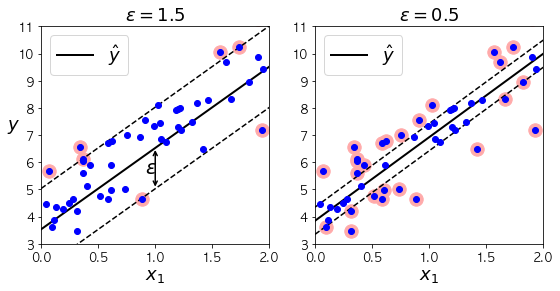

In [15]:
from sklearn.svm import LinearSVR

svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])


def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.subplot(122)
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
plt.show()

- 비선형 회귀 작업을 처리하려면 커널 SVM 모델을 사용
- SVR은 SVC의 회귀 버전이고 LinearSVR은 LinearSVC의 회귀 버전
- LinearSVr은 (LinearSVC처럼) 필요한 시간이 훈련 세트의 크기에 비례해서 선형적으로 늘어남
- 하지만 SVR은 (SVC처럼) 훈련 세트가 커지면 훨씬 느려짐

다음 코드는 (커널 트릭을 제공하는) 사이킷런의 SVR을 사용<br>
임의의 2차방정식 형태의 훈련 세트에 2차 다항 커널을 사용한 SVM 회귀를 보여줌

In [16]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

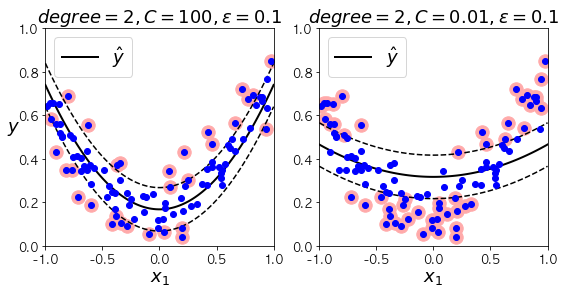

In [17]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", gamma='auto', degree=2, C=100, epsilon=0.1)
svm_poly_reg2 = SVR(kernel="poly", gamma='auto', degree=2, C=0.01, epsilon=0.1)
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.subplot(122)
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
plt.show()

**NOTE_** SVM을 이상치 탐지에도 사용할 수 있음.<br>
https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM

---
## 5.4 SVM 이론

이 절에서 SVM의 예측은 어떻게 이뤄지는지, 그리고 SVM의 훈련 알고리즘이 어떻게 작동하는지 설명함<br>
편향을 b라 하고 특성의 가중치 벡터를 **w**라 하겠음

### 5.4.1 결정 함수와 예측

- 선형 SVM 분류기 모델은 단순히 결정 함수 **w**<sup>T</sup> &middot; **x** + b = w<sub>1</sub>x<sub>1</sub> + &middot;&middot;&middot; + w<sub>n</sub>x<sub>n</sub> + b를 계산해서 새로운 샘플 **x**의 클래스를 예측
- 결괏값이 0보다 크면 예측된 클래스 $\hat{y}$은 양성 클래스(1), 그렇지 않으면 음성 클래스(0)가 됨. [식 5-2] 참조

<img src="./images/equation5-2.png" width="40%">
<center>**식 5-2 선형 SVM 분류기의 예측**</center>

- 아래 [그림 5-12]는 특성이 두 개(꽃잎의 너비와 길이)인 데이터셋이기 때문에 모델의 결정 함수가 2차원 평면임
- 결정 경계는 결정 함수의 값이 0인 점들로 이루어져 있음
- 이는 두 평면의 교차점으로 직선임(굵은 실선)

<img src="./images/figure5-12.png" width="80%">
<center>**그림 5-12 iris 데이터셋의 결정 함수**</center>

- 점선은 결정 함수의 값이 1 또는 -1인 점들을 나타냄
- 이 선분은 결정 경계에 나란하고 일정한 거리만큼 떨어져서 마진을 형성하고 있음
- 선형 SVM 분류기를 훈련한다는 것: 마진 오류를 하나도 발생하지 않거나(하드 마진) 제한적인 마진 오류를 가지면서(소프트 마진) 가능한 한 마진을 크게 하는 **w**와 b를 찾는 것